In [1]:
import os
import keras
from keras import layers,models,optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import time
import shutil
import pickle
import math

# Download dataset
[Download](https://liveeduisegiunl-my.sharepoint.com/:u:/g/personal/m20200597_novaims_unl_pt/EWfJRtW0BRRNoOmYzb6FviQB3_HP_N-rsnPcxm4J7fxEBQ?e=8Mh1xt)

Download file and unzip in the base_dir directory.

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
TrainSamplePercentage = 70
RandomSeed = 42
base_dir = "C:\\Users\\flopes\\Desktop\\CovidChestXRay" # Change to personal folder

# Organize Images

In [4]:
ImageBank = "ImageBank"

In [5]:
ImageBankPath = os.path.join(base_dir, ImageBank)

In [6]:
def create_dir(dir):
    if os.path.exists(dir):
        shutil.rmtree(dir)
    os.makedirs(dir)

In [7]:
covid_images_path = os.path.join(ImageBankPath, 'COVID')
noncovid_images_path = os.path.join(ImageBankPath, 'NOCOVID')

len_covid = int(len(os.listdir(covid_images_path)) * TrainSamplePercentage / 100)
len_no_covid = int(len(os.listdir(noncovid_images_path)) * TrainSamplePercentage / 100)

print(f"COVID - Train Sample Size : {len_covid}")
print(f"NO COVID - Train Sample Size : {len_no_covid}")

COVID - Train Sample Size : 2946
NO COVID - Train Sample Size : 12554


In [8]:
train_path =  os.path.join(base_dir, 'train')
validation_path = os.path.join(base_dir, 'validation')

In [9]:
def CreateTrainAndVal(source_COVID, source_NOCOVID,dest_train,dest_val,TrainSamplePercentage, RandomSeed):
    create_dir(dest_train)
    create_dir(dest_val)
    
    # Create class folder in train
    covid_train_path =  os.path.join(dest_train, 'COVID')
    create_dir(covid_train_path)
    no_covid_train_path = os.path.join(dest_train, 'NOCOVID')
    create_dir(no_covid_train_path)
    
    # Create class folder in val
    covid_val_path =  os.path.join(dest_val, 'COVID')
    create_dir(covid_val_path)
    no_covid_val_path = os.path.join(dest_val, 'NOCOVID')
    create_dir(no_covid_val_path)
    
    
    ImageSplit = train_test_split(os.listdir(source_COVID), test_size=(100-TrainSamplePercentage)/100.0, random_state=RandomSeed)
    
    for image in ImageSplit[0]: # train
        src = os.path.join(source_COVID, image)
        dest = os.path.join(covid_train_path, image)
        shutil.copyfile(src, dest)
        
    for image in ImageSplit[1]: # val
        src = os.path.join(source_COVID, image)
        dest = os.path.join(covid_val_path, image)
        shutil.copyfile(src, dest)

        
    ImageSplit = train_test_split(os.listdir(source_NOCOVID), test_size=(100-TrainSamplePercentage)/100.0, random_state=RandomSeed)
    
    for image in ImageSplit[0]: # train
        src = os.path.join(source_NOCOVID, image)
        dest = os.path.join(no_covid_train_path, image)
        shutil.copyfile(src, dest)
        
    for image in ImageSplit[1]: # val
        src = os.path.join(source_NOCOVID, image)
        dest = os.path.join(no_covid_val_path, image)
        shutil.copyfile(src, dest)

In [10]:
CreateTrainAndVal(covid_images_path, 
                  noncovid_images_path,
                  train_path,
                  validation_path,
                  TrainSamplePercentage, 
                  RandomSeed)

In [11]:
# Reset Keras Session
def reset_keras(model):
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# Transfer Learning

In [12]:
def transferLearning(basemodel,imageprocessor,parameters):
    base_model.trainable = False
    inputs = keras.Input(shape=parameters['input_shape'])
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(2,activation=parameters['activation_output'])(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer=optimizers.Adam(learning_rate=parameters['learning_rate']),
                  loss=parameters['loss_function'],
                  metrics=['acc','AUC'])
    
    
    train_datagen = ImageDataGenerator(preprocessing_function=imageprocessor)
    val_datagen = ImageDataGenerator(preprocessing_function=imageprocessor)

    train_generator=train_datagen.flow_from_directory(train_path,
                                                     color_mode='rgb',
                                                     batch_size=parameters['batch_size'],
                                                     class_mode='categorical',
                                                     shuffle=True)

    val_generator=val_datagen.flow_from_directory(validation_path, 
                                                     color_mode='rgb',
                                                     batch_size=parameters['batch_size'],
                                                     class_mode='categorical',
                                                     shuffle=True)
    
    step_size_train = train_generator.n//train_generator.batch_size
    step_size_val = val_generator.n//val_generator.batch_size

    start_time = time.time()
    history = model.fit(train_generator,
                          steps_per_epoch = step_size_train,
                          validation_data = val_generator,
#                           epochs = 1,
                          epochs = parameters['epochs'],
                          validation_steps = step_size_val
                         )
    
    final_time = (time.time() - start_time)  / 60.0
    return history, final_time

# VGG16

In [13]:
base_model = applications.VGG16(weights='imagenet',
                                    input_shape=(224, 224, 3),
                                    include_top=False)

imageprocessor = applications.vgg16.preprocess_input

tf_parameters = {
    'model_name': 'VGG16',
    'activation_output': 'softmax',
    'filter': 'NA',
    'layers_to_add': 'NA',
    'activation': 'NA',
    'input_shape':(224, 224, 3),
    'epochs': 30,
    'batch_size': 50,
    'learning_rate': 1e-4,
    'loss_function' : 'categorical_crossentropy'
    
}

VGG16Results, VGG16Duration = transferLearning(base_model,imageprocessor,tf_parameters)

Found 15500 images belonging to 2 classes.
Found 6644 images belonging to 2 classes.
Epoch 1/30
310/310 [==============================] - 305s 918ms/step - loss: 0.9294 - acc: 0.6801 - auc: 0.7138 - val_loss: 0.5783 - val_acc: 0.7873 - val_auc: 0.8503
Epoch 2/30
310/310 [==============================] - 260s 838ms/step - loss: 0.5288 - acc: 0.8020 - auc: 0.8665 - val_loss: 0.4480 - val_acc: 0.8191 - val_auc: 0.8928
Epoch 3/30
310/310 [==============================] - 260s 838ms/step - loss: 0.4327 - acc: 0.8238 - auc: 0.8985 - val_loss: 0.3804 - val_acc: 0.8445 - val_auc: 0.9177
Epoch 4/30
310/310 [==============================] - 260s 837ms/step - loss: 0.3468 - acc: 0.8572 - auc: 0.9302 - val_loss: 0.3370 - val_acc: 0.8626 - val_auc: 0.9340
Epoch 5/30
310/310 [==============================] - 261s 841ms/step - loss: 0.3194 - acc: 0.8703 - auc: 0.9404 - val_loss: 0.3105 - val_acc: 0.8730 - val_auc: 0.9451
Epoch 6/30
310/310 [==============================] - 261s 843ms/step - los

In [14]:
print(f"Training Duration: {VGG16Duration} min")

with open('VGG16HistoryDict.pkl', 'wb') as file_pi:
        pickle.dump(VGG16Results.history, file_pi)

Training Duration: 136.54369411468505 min


# Graphs

In [15]:
acc = VGG16Results.history['acc']
val_acc = VGG16Results.history['val_acc']
auc = VGG16Results.history['auc']
val_auc = VGG16Results.history['val_auc']
loss = VGG16Results.history['loss']
val_loss = VGG16Results.history['val_loss']

epochs = range(1,len(acc) + 1)

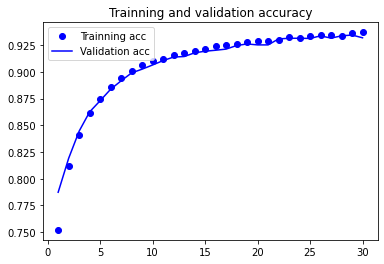

In [16]:
plt.plot(epochs,acc,'bo',label='Trainning acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Trainning and validation accuracy')
plt.legend()

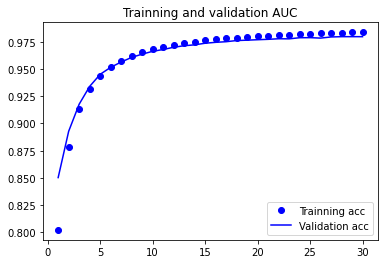

In [17]:
plt.plot(epochs,auc,'bo',label='Trainning acc')
plt.plot(epochs,val_auc,'b',label='Validation acc')
plt.title('Trainning and validation AUC')
plt.legend()

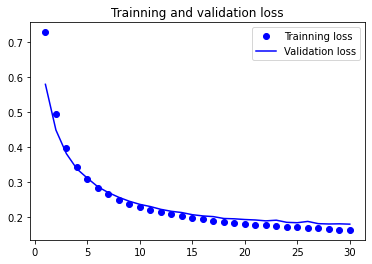

In [18]:
plt.figure()
plt.plot(epochs,loss, 'bo',label='Trainning loss')
plt.plot(epochs,val_loss, 'b', label='Validation loss')
plt.title('Trainning and validation loss')
plt.legend()